In [27]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0-dev20230913


In [28]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-09-13 14:22:40--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.004s  

2023-09-13 14:22:40 (86.1 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2023-09-13 14:22:40--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1    100%[========

## Setup input pipeline



In [29]:
# Good tutorial reference: https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=es-419

# import data

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [30]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [31]:
# adapt labels  to be 0 (ham) or 1 (spam)

train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

train_df.tail()

,type,msg
1387,0,true dear..i sat to pray evening and felt so.s...
1388,0,"what will we do in the shower, baby?"
1389,0,where are you ? what are you doing ? are yuou ...
1390,1,ur cash-balance is currently 500 pounds - to m...
1391,1,not heard from u4 a while. call 4 rude chat pr...


In [32]:
# convert to slices

train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels))

test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels))

test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [33]:
for example, label in train_ds.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'i am in hospital da. . i will return home in evening'
label:  0


In [34]:
# shuffle the data for training and create batches of these (text, label) pairs:

BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [35]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'v skint too but fancied few bevies.waz gona go meet &othrs in spoon but jst bin watchng planet earth&sofa is v comfey; if i dont make it hav gd night'
 b"what's up my own oga. left my phone at home and just saw ur messages. hope you are good. have a great weekend."
 b"i'm taking derek &amp; taylor to walmart, if i'm not back by the time you're done just leave the mouse on my desk and i'll text you when priscilla's ready"]

labels:  [0 0 0]


## Create the text encoder

In [36]:
# The raw text loaded needs to be processed before it can be used in a model.
# The simplest way to process text for training is using the TextVectorization layer.
# This layer has many capabilities, but here sticks to the default behavior.

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [37]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

## Create the model

In [49]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [50]:
history = model.fit(train_ds, epochs=10,
                    validation_data=test_ds,
                    validation_steps=30)

Epoch 1/10
44/44 [==============================] - 34s 364ms/step - loss: 0.6736 - accuracy: 0.8657 - val_loss: 0.6465 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 6s 132ms/step - loss: 0.5945 - accuracy: 0.8657 - val_loss: 0.5373 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 8s 177ms/step - loss: 0.5029 - accuracy: 0.8657 - val_loss: 0.4736 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 9s 201ms/step - loss: 0.4393 - accuracy: 0.8657 - val_loss: 0.4015 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 6s 138ms/step - loss: 0.3478 - accuracy: 0.8657 - val_loss: 0.2811 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 8s 189ms/step - loss: 0.2204 - accuracy: 0.8657 - val_loss: 0.1653 - val_accuracy: 0.8677
Epoch 7/10
44/44 [==============================] - 8s 189ms/step - loss: 0.1346 - accuracy: 0.9461 - val_loss: 0.0981 - val_accuracy: 0.9760
Epoch

In [51]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 1s 30ms/step - loss: 0.0377 - accuracy: 0.9914
Test Loss: 0.03772042691707611
Test Accuracy: 0.9913793206214905


(0.0, 0.7052815735340119)

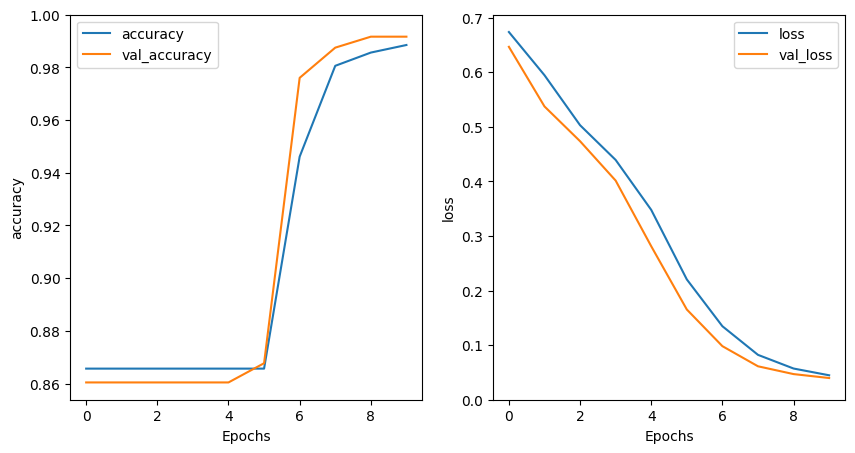

In [52]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [53]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  ps = model.predict([pred_text])
  print(ps)
  p = ps[0][0]
  prediction = [p, "ham" if p <0.5 else "spam"]
  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 6s 6s/step
[[-4.2430115]]
[-4.2430115, 'ham']


In [54]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 63ms/step
[[-4.2430115]]
1/1 [==============================] - 0s 60ms/step
[[0.8925603]]
1/1 [==============================] - 0s 69ms/step
[[-9.793557]]
1/1 [==============================] - 0s 68ms/step
[[2.178292]]
1/1 [==============================] - 0s 61ms/step
[[2.7064552]]
1/1 [==============================] - 0s 47ms/step
[[-8.689068]]
1/1 [==============================] - 0s 41ms/step
[[-8.673344]]
You passed the challenge. Great job!
